<center>
<h1>Machine Learning in Production (MLOps) with AWS</h1>
<hr>
<h1>Using Jupyter Notebooks to Build an XGBoost Model and Deploying it to an Endpoint</h1>
<hr>
<h5>https://www.d-one.ai, July 2022</h5>
<h6>Heiko Kromer (Heiko.Kromer@d-one.ai)</h6>
</center>

<h2>Problem Introduction</h2>

<div class="alert alert-info">🚨<strong>Add link to EDA notebook</strong></div>

In this notebook, we will set up and end-to-end process to preprocess, train, and deploy an XGBoost model to an endpoint in AWS SageMaker. The dataset we use is taken from WinJi (https://www.win-ji.com), which is an asset management platform for renewables. The dataset contains various physical measurements as per the column definition below:

| Column name        | Description                                                                           | Unit | Data Type |
|:-------------------|:--------------------------------------------------------------------------------------|:-----|:----------|
| wt_sk              | Unique device identifier, equivalent to device name                             | -    | float     |
| measured_at        | Data timestemp in UTC format                                                          | -    | string    |
| wind_speed         | Average apparent wind speed measured by nacelle anemometer, normalised to rated value | m/s  | float     |
| power              | Average measured power production, normalised to rated max power                      | W    | float     |
| nacelle_direction  | Average position of nacelle relative to North (E=90°)                                 | °    | float     |
| wind_direction     | Average direction of incoming wind relative to North (E=90°)                          | °    | float     |
| rotor_speed        | Average revolutions per minute of the low speed rotor, normalised to rates RS         | -    | float     |
| generator_speed    | Average revolutions per minute of the generator, normalised to rated GS               | -    | float     |
| temp_environment   | Average outside temperature on nacelle height                                         | °C   | float     |
| temp_hydraulic_oil | Average oil temperature                                                               | °C   | float     |
| temp_gear_bearing  | Average gear temperature                                                              | °C   | float     |
| cosphi             | Average power factor of device                                                        | -    | float     |
| blade_angle_avg    | Average pitching angles, averaged over blades                                         | °    | float     |
| hydraulic_pressure | Average pressure in hydraulic circuit                                                 | mBar | float     |
| subtraction        | Error flag (NaN: no error, 0/1: error)                                                | -    | float     |
| categories_sk      | Categorisation of error type                                                          | -    | float     |

Values have been obfuscated and white noise added to prevent leakage of proprietary information. For details on the exploration of the dataset, see the data exploration notebook.

The goal in this notebook is to use AWS SageMaker to predict an error state for a turbine (column `subtraction`) using an XGBoost model.

# Setting up shop

A known challenge with SageMaker Studio default libraries is that they are often outdated. In this case, we want to make sure that pandas and s3fs is up-to-date. s3fs is a file system interface for S3 (https://pypi.org/project/s3fs/).

We also want to install XGBoost to visualize the feature importances of the model. We will not use this installed XGBoost package, but run the model in a container preconfigure by AWS.

In [16]:
%pip install --upgrade pip
%pip install pandas s3fs --upgrade
%pip install xgboost==1.6.1

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached s3fs-2022.5.0-py3-none-any.whl (27 kB)
  Using cached fsspec-2022.5.0-py3-none-any.whl (140 kB)
  Using

# Import packages
We need a few packages, let's import them. Notably is the `boto3` package, which is AWS's SDK for Python. It is named after a dolphin that is swimming in the Amazonas river (https://en.wikipedia.org/wiki/Amazon_river_dolphin).

In [17]:
from IPython.display import FileLink, FileLinks
from datetime import datetime, timedelta
from sagemaker.debugger import Rule, rule_configs
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from typing import List

import boto3
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle as pkl
import sagemaker
import tarfile
import xgboost


pd.options.mode.chained_assignment = None  # default='warn'

# Set up global variables

We will set a up a few variables to make our lifes easier.

Let us first check on the role that resources created from our code will assume to leverage other AWS resources via API calls. In case we need additional permissions, we can edit the role policy in IAM.

In [18]:
# This is the role that SageMaker assumes to leverage AWS resources
ROLE = sagemaker.get_execution_role()
ROLE

'arn:aws:iam::451811961115:role/AmazonSageMaker-ExecutionRole-20200526T075798'

Below are our definitions for the paths. We want the artifacts created from the compute instances to be copied into an S3 bucket. The processed data will be placed into a folder that is prefixed with the current time to ensure uniqueness of the output folder. 

<div class="alert alert-info"> 🎯 <strong> Edit S3 bucket name </strong>
    
Replace the bucket name with the name of your bucket. Note that the permissions of the bucket must allow access to the role. In my case, I have given the role full access to the S3 bucket named "aws-sagemaker-blogpost".
</div>


In [19]:
# Paths for the containers that we will create
# S3 Bucket where the data is stored
BUCKET_NAME = "aws-sagemaker-blogpost"  # Put your S3 bucket name here
BUCKET = f's3://{BUCKET_NAME}'

# Raw data paths
RAW_DATA_FOLDER = 'data'
# Note if you change the line below, you also need to change it in the cell that creates the prepare_data.py
RAW_DATA_FILE = 'wind_turbines.csv'
RAW_DATA_PATH = os.path.join(BUCKET, RAW_DATA_FOLDER, RAW_DATA_FILE)

# Path where the processed objects will be stored
now = datetime.now() # get current time to ensure uniqueness of the output folders
PROCESSED_DATA_FOLDER = 'processed_' + now.strftime("%Y-%m-%d_%H%M_%S%f")
PROCESSED_DATA_PATH = os.path.join(BUCKET, PROCESSED_DATA_FOLDER)

# Paths for model train, validation, test split
TRAIN_DATA_PATH = os.path.join(PROCESSED_DATA_PATH, 'train.csv')
TRAIN_DATA_PATH_W_HEADER = os.path.join(PROCESSED_DATA_PATH, 'train_w_header.csv')
VALIDATION_DATA_PATH = os.path.join(PROCESSED_DATA_PATH, 'validation.csv')
TEST_DATA_PATH = os.path.join(PROCESSED_DATA_PATH, 'test.csv')
TEST_DATA_PATH_W_HEADER = os.path.join(PROCESSED_DATA_PATH, 'test_w_header.csv')

# Path to model output data
MODEL_OUTPUT = os.path.join(BUCKET, 'output')

In [20]:
# Job name for preprocessing, you can pick any name
PREPROCESSING_JOB_NAME= 'windTurbinesPreprocessing'

# Preprocessing

<div class="alert alert-info">🚨<strong>Add link to EDA notebook</strong></div>

The data comes in chunks, but for our purposes, we would like to have one large file with data. We could also extend the code to read only new data and add it to the file, but for simplicity, let's load the whole dataset for processing.

Note: Having the data in chunks would allow for online processing of new data when it comes in, e.g., when a turbine reports the next couple of months data. We could set this up easily with EventBridge for example.

For details on the dataset, see the exploratory data analysis notebook.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format. Here, we stick to CSV. The requirements on the data formatting are:

1. The target variable must be in the first column.
2. There cannot be a header row.

We first create a preprocessing script that will be used by a built-in SKLearn container to run the preprocessing job of our pipeline. Running the cell below will produce a Python file whose content is the same as the cell's content and named `prepare_data.py`. It will be saved in the notebooks instance path (see left pane of the SageMaker Studio JupyterLab). We need to provide the constants in the cell (and redefine for example the dataset file name). Reason is that the cell below creates a file (prepare_data.py) which is provided to the preprocessing instance.

We then define the container that will read in the data from the S3 bucket and use this script to preprocess it and then write the processed files back to the S3 bucket. 

## Preprocessing steps

We are applying the following preprocessing steps:

1. Filtering out low power values
    - We set a threshold of 0.05 W. Measurements with power values below this threshold are not considered because the turbines might have been in a non working state.
2. Process target column
    - We replace the two error types 1 and 0 with 1.
    - We fill nulls with 0.
3. Fill nulls in all of the feature columns
    - We select only relevant column of the dataframe and fill nulls in the dataframe with 0.
4. Select only relevant columns
    - We make sure the target column is in the first column of the dataframe.

In [21]:
%%writefile prepare_data.py

import argparse
import logging
import os
import pandas as pd
from datetime import datetime, timedelta
from typing import List, Tuple, Union

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

pd.options.mode.chained_assignment = None  # default='warn'


# ----- CONSTANTS ----- #
# Columns of df
# Error column <> target
COL_ERRORS = 'subtraction'
# Power produced column (used for filtering out small values)
COL_POWER = 'power'
# Features to consider for the model
FEATURES = ['wind_speed', 'power', 'nacelle_direction', 'wind_direction',
            'rotor_speed', 'generator_speed', 'temp_environment',
            'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi',
            'blade_angle_avg', 'hydraulic_pressure']
# Power values to filter out
MIN_POWER = 0.05
# Filname of the raw data file
RAW_DATA_FILE = 'wind_turbines.csv'


def assert_col_of_df(df: pd.DataFrame, col: Union[List[str], str]) -> None:
    """Helper function to assert that a column `col` is a column of `df`.
    
    Args:
        df: Dataframe.
        col: String value to test.
    
    Returns:
        None.
        
    Raises:
        ValueError if `col` is not a column of `df`.
    """
    if isinstance(col, str):
        col = [col]

    for c in col:
        try:
            assert c in df.columns      
        except AssertionError:
            raise ValueError(f"Invalid input value. Column {c} is not a column of df.")

            
def get_train_test_split(
        df: pd.DataFrame,
        n_days_test: int
        ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Splits the input data frame into a training and test set.

    Args:
        df: Raw input data.
        n_days_test: Number of days to consider for the test split. The n_days_test last 
            days of the input data will be selected for the test split.

    Returns:
        Tuple[pd.DataFrame]: Raw train and test data splits.
    """
    _date_col = 'date'
    _measured_at_col = 'measured_at'
    
    assert_col_of_df(df=df, col=_measured_at_col)
    
    # Take only the date part of the string, i.e., the first 10 characters
    df[_date_col] = df[_measured_at_col].apply(lambda x: x[:10])
    # Convert to date object
    df[_date_col] = pd.to_datetime(df[_date_col], format='%Y-%m-%d')
    
    # Get the test dates
    min_date = df[_date_col].min()
    max_date = df[_date_col].max()
    
    test_dates = [
        datetime.strftime(max_date - timedelta(days=i), '%Y-%m-%d') for i in range(n_days_test)
    ]
    
    df_train = df[~df[_date_col].isin(test_dates)].drop(_date_col, axis=1)
    df_test = df[df[_date_col].isin(test_dates)].drop(_date_col, axis=1)
    
    logger.info(f"Train set ranges from {min_date} until {min(test_dates)} (not included).")
    logger.info(f"Test set ranges from {min(test_dates)} until {max(test_dates)}.")
    
    return df_train, df_test


def fill_nulls(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """Fills nulls in column `col` of dataframe `df`.
    
    Args:
        df: Raw input dataframe.
        col: Column of `df` with nulls filled with 0.
        
    Returns:
        pd.DataFrame: Dataframe with nulls filled.
    """
    assert_col_of_df(df=df, col=col)
        
    df.loc[:, col] = (
        df
        .loc[:, col]
        .fillna(0)
    )
    
    logger.info(f"Filled nulls in column {col} with 0.")

    return df


def filter_power(df: pd.DataFrame, col_power: str, min_power: float) -> pd.DataFrame:
    """Filters the `df` on the power column `col_power`.
    
    
    Args:
        df: Raw input dataframe.
        col_power: Column of `df` with the power production.
        min_power: Minimum values of power production considered. Rows with smaller
            values are filtered out.
        
    Returns:
        pd.DataFrame: Dataframe filtered on `min_power`.
    """
    assert_col_of_df(df=df, col=col_power)
    
    filter_power = df[col_power] > min_power
    
    rowcount_before = df.shape[0]
    df = (
        df
        .loc[filter_power]
    )
    rowcount_after = df.shape[0]
    logger.info(f"Removed {rowcount_before-rowcount_after} rows which had power below {min_power}.")
    
    return df


def process_target(df: pd.DataFrame, col_target: str) -> pd.DataFrame:
    """Processes the target column by:
        1. Replacing error types 1 and 0 with 1.
        2. Filling nulls with 0.
        3. Make sure the target column is in the first column of the dataframe.
    
    Args:
        df: Raw input dataframe.
        col_target: Target column
    
    Returns:
        pd.DataFrame: Dataframe with target column processed.
    """
    assert_col_of_df(df=df, col=col_target)
    
    # Make sure that the 0 error type is also mapped to 1 (we do a binary classification later)
    df.loc[df[col_target] == 0, col_target] = 1
    
    df = fill_nulls(df=df, col=col_target)
    
    # Reorder columns
    colnames = list(df.columns)
    colnames.insert(0, colnames.pop(colnames.index(col_target)))
    df = df[colnames]
    
    return df


def wrap_transform_data(
    df: pd.DataFrame,
    col_power: str,
    min_power: float,
    features: List[str],
    target: str
    ) -> pd.DataFrame:
    """Wrapper for transforming the data for the model
    
    Processing is applied in the following steps:
        1. Filtering out low power values
        2. Process target column
        3. Fill nulls in all of the feature columns
        4. Select only relevant columns
        
    Args:
        df: Input dataframe.
        col_power: Column of `df` with the power production.
        min_power: Minimum values of power production considered. Rows with smaller
            values are filtered out.
        features: List of the features to be included in the transformation.
        target: Target column.
    
    Returns:
        pd.DataFrame: Transformed dataframe.
    """
    # 1. Filter out low power
    df = filter_power(df=df, col_power=col_power, min_power=min_power)
    
    # 2. Process target clumn
    df = process_target(df=df, col_target=target)

    # 3. Fill nulls in all of the feature columns and select them
    for feat in features:
        df = fill_nulls(df=df, col=feat)
    
    # 4. Select only relevant columns
    df = df[[target] + features]
    
    return df


if __name__ == '__main__':
    
    logger.info(f'Preprocessing job started.')
    # Parse the SDK arguments that are passed when creating the SKlearn container
    parser = argparse.ArgumentParser()
    parser.add_argument("--n_test_days", type=int, default=10)
    parser.add_argument("--n_val_days", type=int, default=10)
    args, _ = parser.parse_known_args()

    logger.info(f"Received arguments {args}.")

    # Read in data locally in the container
    input_data_path = os.path.join("/opt/ml/processing/input", RAW_DATA_FILE)
    logger.info(f"Reading input data from {input_data_path}")
    # Read raw input data
    df = pd.read_csv(input_data_path)
    logger.info(f"Shape of data is: {df.shape}")

    # ---- Preprocess the data set ----
    logger.info("Split data into training+validation and test set.")
    df_train_valid, df_test = get_train_test_split(df=df, n_days_test=args.n_test_days) 

    logger.info("Split training+validation into training and validation set.")
    df_train, df_val = get_train_test_split(df=df_train_valid, n_days_test=args.n_val_days) 

    logger.info("Transforming training data.")
    train = wrap_transform_data(
        df=df_train,
        col_power=COL_POWER,
        min_power=MIN_POWER,
        features=FEATURES,
        target=COL_ERRORS
    )
    
    logger.info("Transforming validation data.")
    val = wrap_transform_data(
        df=df_val,
        col_power=COL_POWER,
        min_power=MIN_POWER,
        features=FEATURES,
        target=COL_ERRORS
    )

    logger.info("Transforming test data.")
    test = wrap_transform_data(
        df=df_test,
        col_power=COL_POWER,
        min_power=MIN_POWER,
        features=FEATURES,
        target=COL_ERRORS
    )
    
    # Create local output directories. These directories live on the container that is spun up.
    try:
        os.makedirs("/opt/ml/processing/train")
        os.makedirs("/opt/ml/processing/validation")
        os.makedirs("/opt/ml/processing/test")
        print("Successfully created directories")
    except Exception as e:
        # if the Processing call already creates these directories (or directory otherwise cannot be created)
        logger.debug(e)
        logger.debug("Could Not Make Directories.")
        pass

    # Save data locally on the container that is spun up.
    try:
        pd.DataFrame(train).to_csv("/opt/ml/processing/train/train.csv", header=False, index=False)
        pd.DataFrame(train).to_csv("/opt/ml/processing/train/train_w_header.csv", header=True, index=False)
        pd.DataFrame(val).to_csv("/opt/ml/processing/validation/val.csv", header=False, index=False)
        pd.DataFrame(val).to_csv("/opt/ml/processing/validation/val_w_header.csv", header=True, index=False)
        pd.DataFrame(test).to_csv("/opt/ml/processing/test/test.csv", header=False, index=False)
        pd.DataFrame(test).to_csv("/opt/ml/processing/test/test_w_header.csv", header=True, index=False)
        logger.info("Files Successfully Written Locally")
    except Exception as e:
        logger.debug("Could Not Write the Files")
        logger.debug(e)
        pass

    logger.info("Finished running processing job")

Overwriting prepare_data.py


If one reads the script carefully one can see that the training, validation, and test datasets are stored in the file path `/opt/ml/processing/...`. This is not the path in the S3 bucket, but refers to the local path on the container that is spun up. We supply the input data below when running the processor (see argument `inputs`).

We specified that in the beginning when setting up path variables (e.g., `TEST_DATA_PATH`)! This will become useful later.
The first line of the cell's output will indicate the job's name. Go back to the AWS SageMaker Console and check the processing jobs. In my case - eu-central-1 AZ - the link is https://eu-central-1.console.aws.amazon.com/sagemaker/home?region=eu-central-1#/processing-jobs.

From there, one can leverage CloudWatch to check the logs for the job or make use of other monitoring tools - the full power of AWS can be leveraged.

In [22]:
%%time

base_job_name = PREPROCESSING_JOB_NAME
sklearn_processor = SKLearnProcessor(
    base_job_name=base_job_name,
    framework_version="0.20.0",
    role=ROLE,
    instance_type="ml.m5.xlarge",
    instance_count=1
)

sklearn_processor.run(
    code="prepare_data.py",
    inputs=[
        ProcessingInput(
            source=RAW_DATA_PATH,
            destination="/opt/ml/processing/input"
        )
    ],
    outputs=[
        ProcessingOutput(
            destination=PROCESSED_DATA_PATH,
            source="/opt/ml/processing/train"
        ),
        ProcessingOutput(
            destination=PROCESSED_DATA_PATH,
            source="/opt/ml/processing/validation"
        ),
        ProcessingOutput(
            destination=PROCESSED_DATA_PATH,
            source="/opt/ml/processing/test"
        ),
    ],
    arguments=[
        "--n_test_days", "20",
        "--n_val_days", "30"
    ],
)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()


Job Name:  windTurbinesPreprocessing-2022-06-17-16-54-11-464
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://aws-sagemaker-blogpost/data/wind_turbines.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-central-1-451811961115/windTurbinesPreprocessing-2022-06-17-16-54-11-464/input/code/prepare_data.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'output-1', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://aws-sagemaker-blogpost/processed_2022-06-17_1654_11176216', 'LocalPath': '/opt/ml/processing/train', 'S3UploadMode': 'EndOfJob'}}, {'OutputName': 'output-2', 'AppManaged': False, 'S3Output': {'S3Uri

# Training

For this classification task, we use a bult-in XGBoost container provided by SageMaker. With `sagemaker.image_uri` we specify the training container image URI. In our case, the SageMaker XGBoost training container URI is specified using `sagemaker.image_uris.retrieve`.

You can find information on pre-built containers for example here
https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html or by exploring the SageMaker example notebooks.

In [23]:
region_name = boto3.Session().region_name
container = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region_name,
    version="1.0-1",
    py_version="py3"
)

print(f'Using SageMaker container: {container} in region {region_name}')

Using SageMaker container: 492215442770.dkr.ecr.eu-central-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3 in region eu-central-1


We define the SageMaker Estimator with resource configurations and hyperparameters to train a logistic binary classifier on an c4.4xlarge instance. For different types of EC2 instances available from SageMaker, see https://aws.amazon.com/ec2/instance-explorer/?ec2-instances-cards.sort-by=item.additionalFields.category-order&ec2-instances-cards.sort-order=asc&awsf.ec2-instances-filter-category=*all&awsf.ec2-instances-filter-processors=*all&awsf.ec2-instances-filter-accelerators=*all&awsf.ec2-instances-filter-capabilities=*all

Specifying the `rules` with `create_xgboost_report()` creates an XGBoost report that provides insights into the training progress and results (see more information here: https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-training-xgboost-report.html).


In [24]:
session = sagemaker.Session()
xgboost_model = sagemaker.estimator.Estimator(
    container,
    role=ROLE, 
    instance_count=1, 
    instance_type='ml.c4.4xlarge',
    output_path=MODEL_OUTPUT,
    sagemaker_session=session,
    rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]
)

# set the model's hyperparameters
xgboost_model.set_hyperparameters(
    objective='binary:logistic',
    num_round=50,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
    silent=0,
)

In [27]:
train_data = sagemaker.inputs.TrainingInput(
            s3_data=f'{PROCESSED_DATA_PATH}/train.csv',
            distribution='FullyReplicated',
            content_type="text/csv",
            s3_data_type='S3Prefix')

validation_data = sagemaker.inputs.TrainingInput(
                s3_data=f'{PROCESSED_DATA_PATH}/val.csv',
                distribution='FullyReplicated',
                content_type="text/csv",
                s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data}

In [ ]:
%%time

xgboost_model.fit(inputs=data_channels, logs='All', wait=True)

2022-06-17 17:02:42 Starting - Starting the training job...
2022-06-17 17:03:09 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
ProfilerReport-1655485362: InProgress
......
2022-06-17 17:04:10 Downloading - Downloading input data...
2022-06-17 17:04:28 Training - Downloading the training image...

In [ ]:
xgboost_report_path = xgboost_model.output_path + '/' + xgboost_model.latest_training_job.job_name + "/rule-output"

! aws s3 ls {xgboost_report_path} --recursive
! aws s3 cp {xgboost_report_path} ./ --recursive

In [ ]:
display("Click link below to view the XGBoost Training report", FileLink("CreateXgboostReport/xgboost_report.html"))

# Evaluation and Feature Importance

After training, we want to evaluate the model and in particular find out what importance the model gives to each of the features.

For that, we first copy the model to the path where this notebook is running to import it. For this, we need to have `xgboost` imported locally as we did in the beginning.

In [ ]:
model_path = f'{xgboost_model.output_path}/{xgboost_model.latest_training_job.job_name}/output/model.tar.gz'

!aws s3 cp $model_path "model.tar.gz"

#opens the downloaded model artifcat and loads it as 'model' variable
tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()
model = pkl.load(open('xgboost-model', 'rb'))

Out of the box, the model does not contain column headers, hence we do not know what feature is which, only the order is preserved. We can map the features from the earlier defined processed dataset with headers to the xgboost model features.

In [ ]:
df = pd.read_csv(TRAIN_DATA_PATH_W_HEADER)
map_names = dict(zip(model.get_fscore().keys(), list(df.columns)[1:]))
map_names

Let's plot the feature importances

In [ ]:

model.feature_names = list(map_names.values())
#plot feature importance
fig, ax = plt.subplots(figsize=(10,10))
xgboost.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = False)
plt.title('Feature Importance')
plt.show()



This result is somewhat surprising, as we see that the wind speed and blade angle have a high effect on the outcome of the model. We will stop this investigation here, we could go deeper with SHAP values and try to understand the models predictions. For the purpose of this notebook, we leave it here, though.



# Invoking the endpoint

In [41]:
model_endpoint = xgboost_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-------!

In [42]:
def convert_df_to_csv_object(df: pd.DataFrame) -> str:
    """Converts the dataframe object `df` to a payload that can be passed to the model endpoint.
    
    Args:
        df: Dataframe that is converted to a csv-file for the SageMaker model's endpoint.
    
    Returns:
        payload_as_csv: csv-file as payload.
    """
    
    assert isinstance(df, pd.DataFrame)
    
    csv_file = io.StringIO()
    # by default sagemaker expects comma seperated
    df.to_csv(csv_file, sep=",", header=False, index=False)
    
    payload_as_csv = csv_file.getvalue()
    
    return payload_as_csv

In [43]:


def batch_prediction(payload: str, endpoint: sagemaker.predictor.Predictor) -> List[float]:
    """Function to pass a single payload to the model endpoint and return a prediction.
    
    Args:
        payload: SageMaker model friendly payload (feature vector).
        endpoint: SageMaker model endpoint.
    
    Returns:
        response: List of predictions from the model.
    """
    
    # invoke the endpoint to get a prediction
    response = endpoint.predict(payload, initial_args={'ContentType': "text/csv"})
    
    # process predictions
    response = response.decode("utf-8")
    
    response = [float(i) for i in response.split(',')]
    
    # convert to array
    response = np.asarray(response)
      
    return response

## Confusion matrix training and test data

In [44]:


def create_confusion_matrix(true: np.ndarray, prediction: np.ndarray):
    c_mat = confusion_matrix(true, prediction)
    
    return c_mat

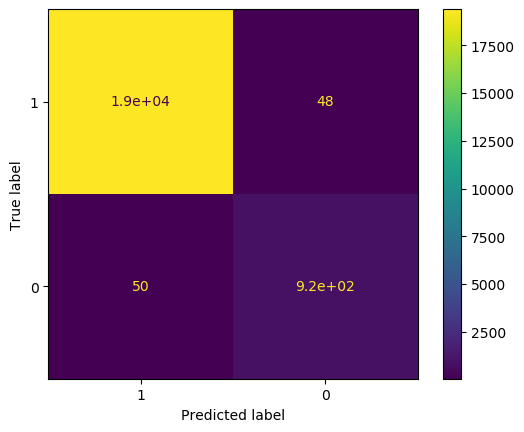

In [47]:
THRESHOLD = 0.5

train_data = pd.read_csv(TRAIN_DATA_PATH_W_HEADER)
train_features = train_data.iloc[:, 1:]

prediction = batch_prediction(
    payload=convert_df_to_csv_object(df=train_features),
    endpoint=model_endpoint
)
prediction_binary = np.where(prediction > THRESHOLD, 1, 0)

cm = create_confusion_matrix(true=train_data.iloc[:, 0].values, prediction=prediction_binary)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot()
plt.show()

In [49]:
prediction_binary

array([0, 0, 0, ..., 1, 1, 1])

In [50]:
prediction

array([1.44018108e-04, 1.38201634e-04, 1.38201634e-04, ...,
       9.88947511e-01, 9.98106360e-01, 9.96254921e-01])

AUC is 0.9729
Accuracy is 0.9952
Recall is 0.9482
Precision is 0.9502


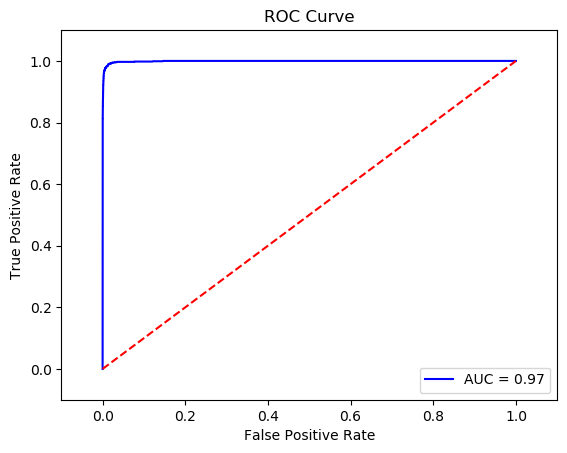

In [48]:
auc = round(roc_auc_score(train_data.iloc[:, 0].values, prediction_binary), 4)
accuracy = round(accuracy_score(train_data.iloc[:, 0].values, prediction_binary), 4)
recall = round(recall_score(train_data.iloc[:, 0].values, prediction_binary), 4)
precision = round(precision_score(train_data.iloc[:, 0].values, prediction_binary), 4)
print(f'AUC is {auc}')
print(f'Accuracy is {accuracy}')
print(f'Recall is {recall}')
print(f'Precision is {precision}')


fpr, tpr, _ = metrics.roc_curve(train_data.iloc[:, 0].values, prediction)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

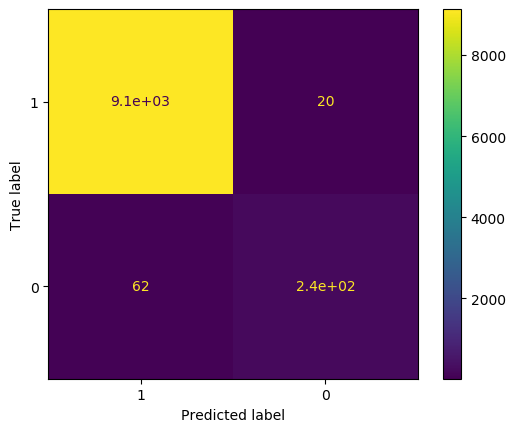

In [51]:
test_data = pd.read_csv(TEST_DATA_PATH_W_HEADER)
test_features = test_data.iloc[:, 1:]

prediction = batch_prediction(
    payload=convert_df_to_csv_object(df=test_features),
    endpoint=model_endpoint
)
prediction_binary = np.where(prediction > THRESHOLD, 1, 0)

cm = create_confusion_matrix(true=test_data.iloc[:, 0].values, prediction=prediction_binary)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot()
plt.show()

AUC is 0.8956
Accuracy is 0.9913
Recall is 0.7933
Precision is 0.9225


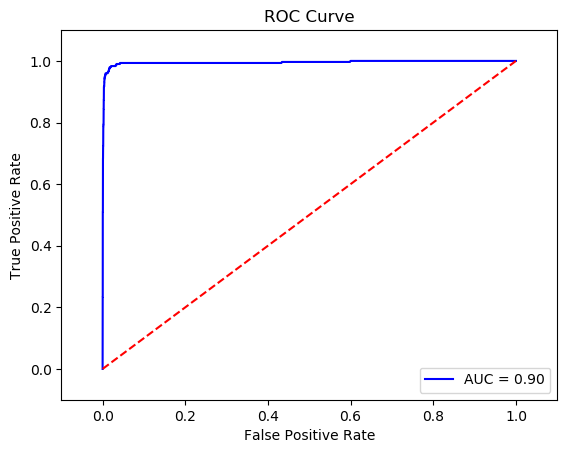

In [52]:
auc = round(roc_auc_score(test_data.iloc[:, 0].values, prediction_binary), 4)
accuracy = round(accuracy_score(test_data.iloc[:, 0].values, prediction_binary), 4)
recall = round(recall_score(test_data.iloc[:, 0].values, prediction_binary), 4)
precision = round(precision_score(test_data.iloc[:, 0].values, prediction_binary), 4)
print(f'AUC is {auc}')
print(f'Accuracy is {accuracy}')
print(f'Recall is {recall}')
print(f'Precision is {precision}')

fpr, tpr, _ = metrics.roc_curve(test_data.iloc[:, 0].values, prediction)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
test_data['subtraction'].value_counts()